In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Copyright 2016 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""
  AutoNLP datasets.
"""

import os
import numpy as np

class AutoNLPDataset(object):
    def __init__(self, dataset_dir):
        """
            train_dataset, test_dataset: list of strings
            train_label: np.array
        """
        self.dataset_name_ = dataset_dir
        self.dataset_dir_ = dataset_dir
        self.metadata_ = self.read_metadata(os.path.join(dataset_dir, "meta.json"))

    def read_dataset(self):
        self.train_dataset = self._read_dataset(os.path.join(self.dataset_dir_, "train.data"))
        self.train_label = self.read_label(os.path.join(self.dataset_dir_, "train.solution"))
        self.test_dataset = self._read_dataset(os.path.join(self.dataset_dir_, "test.data"))

    def get_train(self):
        return self.train_dataset, self.train_label

    def get_test(self):
        return self.test_dataset

    def get_metadata(self):
        return self.metadata_

    def read_metadata(self, metadata_path):
        import json
        return json.load(open(metadata_path))

    def _read_dataset(self, dataset_path):
        with open(dataset_path) as fin:
            return fin.readlines()

    def read_label(self, label_path):
        return np.loadtxt(label_path)

    def get_class_num(self):
        """ return the number of class """
        return self.metadata_["class_num"]

    def get_train_num(self):
        """ return the number of train instance """
        return self.metadata_["train_num"]

    def get_test_num(self):
        """ return the number of test instance """
        return self.metadata_["test_num"]

    def get_language(self):
        """ ZH or EN """
        return self.metadata_["language"]

In [0]:

import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import jieba

from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch.autograd as autograd

### Fun Utils

In [0]:
def clean_en_text(dat):

    REPLACE_BY_SPACE_RE = re.compile('["/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')

    ret = []
    for line in dat:
        # text = text.lower() # lowercase text
        line = REPLACE_BY_SPACE_RE.sub(' ', line)
        line = BAD_SYMBOLS_RE.sub('', line)
        line = line.strip()
        ret.append(line)
    return ret

def clean_zh_text(dat):
    REPLACE_BY_SPACE_RE = re.compile('[“”【】/（）：！～「」、|，；。"/(){}\[\]\|@,\.;]')

    ret = []
    for line in dat:
        line = REPLACE_BY_SPACE_RE.sub(' ', line)
        line = line.strip()
        ret.append(line)
    return ret


def _tokenize_chinese_words(text):
    return ' '.join(jieba.cut(text, cut_all=False))

## Get Data

In [0]:
dataset_path = '/content/drive/My Drive/autonlp_starting_kit-master/offline_data/O1/O1.data'
autoDaset = AutoNLPDataset(dataset_path)
autoDaset.read_dataset()

In [0]:
x_data, y_data = autoDaset.get_train()

In [58]:
# take a look at the what the data look like
print(x_data[:5])
print(y_data[:5])

['a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films \n', 'apparently reassembled from the cutting-room floor of any given daytime soap . \n', "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes . \n", 'this is a visually stunning rumination on love , memory , history and the war between art and commerce . \n', "jonathan parker 's bartleby should have been the be-all-end-all of the modern-office anomie films . \n"]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [59]:
num_class = autoDaset.get_metadata()['class_num']
print('number of classes : ', num_class)

number of classes :  2


## Data pre-processing

- The data has many punctuations, we can replace it by space.

- There is not valid set, so we will split the whole dataset into transet ans valid set to better generate the training and hyper-parameters.

- Each observation is a sentence which is hard to translated into presentation, we will split it to tokens.

- We will convert data to Pytorch tensors so they can be used in a neural network. To do that, you must first create a dictionnary that will map words to integers. Add to the dictionnary only words that are in the training set

clean sentences

In [0]:

if autoDaset.get_metadata()['language'] == 'ZH':
    x_data = clean_zh_text(x_data)
    x_data = list(map(_tokenize_chinese_words, x_data))
else:
    x_data = clean_en_text(x_data)

In [61]:
print('number of transet : ', len(x_data))

number of transet :  7792


tokenize dataset

In [62]:
x_data = list(map(word_tokenize, x_data))
x_data[0]

['a',
 'stirring',
 'funny',
 'and',
 'finally',
 'transporting',
 'reimagining',
 'of',
 'beauty',
 'and',
 'the',
 'beast',
 'and',
 '1930s',
 'horror',
 'films']

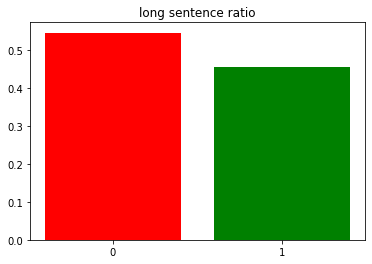

In [68]:
long_n = np.mean(np.array(list(map(len, x_data)))>15)
ticklabels = ['long sentences','short sentences']
plt.bar(range(2), [long_n,1-long_n],color='rgb',tick_label=class_name)
plt.title('long sentence ratio')
plt.show()


Split into train set and valid set

In [0]:
# split data into transet and valset
X_train, X_val, Y_train, Y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=True)

In [22]:
print('N X_train : ', len(X_train))
print('N X_val : ', len(X_val))

N X_train :  6233
N X_val :  1559


In [0]:
# onhot encode to category
def ohe2cat(label):
    return np.argmax(label, axis=1)
Y_train, Y_val = ohe2cat(Y_train), ohe2cat(Y_val)

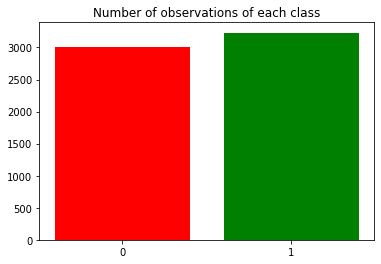

In [25]:
## compute number of occurence of each class
num_class = autoDaset.get_class_num()

class_name = [i for i in range(num_class)]
class_n = [np.sum(Y_train==class_name[i])  for i in range(num_class)]

plt.bar(range(num_class), class_n,color='rgb',tick_label=class_name)
plt.title('Number of observations of each class')
plt.show()

## it is balanced, good

In [32]:
sentences_length = np.array(list(map(len,X_train)))
np.mean(sentences_length > 15)

0.5456441520936949

Create a dictionnary that will map words to integers

In [0]:
dictionary = {}
num_voc = 0
for sentence in X_train:
    for word in sentence:
        if word not in dictionary.keys():
            dictionary[word] = num_voc
            num_voc += 1
dictionary['UNK'] = num_voc
num_voc+=1

In [0]:
def to_tensor(data):
    d = []
    for word in data:
        if word in dictionary.keys():
            d.append(dictionary[word])
    return th.tensor(d)

def to_index(data):
    d = []
    for word in data:
        if word in dictionary.keys():
            d.append(dictionary[word])
        else:
            d.append(dictionary['UNK'])
    return d

## The model

- The dataset can not be encoded by one-hot, but embedding is a good choice. So it takes as input a tensor that is a sequence of integers indexing word embeddings.

- a

In [0]:
class My_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, class_num):
        super(My_classifier, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 32)
        if class_num == 2:
          self.linear2 = nn.Linear(32, 1)
        else:
          self.linear2 = nn.Linear(32, class_num)
        
        nn.init.kaiming_uniform_(self.linear1.weight.data)
        nn.init.kaiming_uniform_(self.linear2.weight.data)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).sum(0)
        out = th.relu(self.linear1(embeds.view(1,-1)))
        out = self.linear2(out)
        #log_probs = th.log_softmax(out, dim=1)
        return out
        

In [0]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def evaluate(model, datas, labels):
    '''
    function for evaluation
    model : pytorch model
    datas : dataset 
    labels : labels

    return : accuracy
    '''
    # nb of good prediction
    good = 0
    # nb of false prediction
    total = 0

    # for each paire of x,y 
    for x,y in zip(datas,labels):
        # make x to Tensor
        x = to_tensor(x)
        # if number of words in a sentence is smaller than size of slide window
        total += 1
        if x.size()[0] <= 0:
            continue
        # we break
        # get result of model
        out = model(x)
    
        if num_class == 2:
            if (out[0].item() >= 0) == (y == 1.):
                good += 1
        else:
        
            if np.argmax(out.detach().numpy()) == y:
                good += 1
    return good/total

def train(model, optimizer, criterion, data, labels):
    total_loss = 0
    data, labels = shuffle(data, labels)
    for x, y in zip(data, labels):
        # reset the gradient
        optimizer.zero_grad()
#         if to_tensor(x).size()[0] <= WINDOW-1:
#             continue
        # output of the model
        output = model(to_tensor(x))
        # compute the loss
        loss = criterion(output, th.tensor([y]))
        total_loss += loss.item()
        loss.backward()  # compute gradient
        #torch.nn.utils.clip_grad_value_(model.parameters(), 5.)  # clip gradient if its norm exceed 5
        optimizer.step()  # update parameters
    
    return model,total_loss/len(data)

def training_loop(model, optimizer, loss_function, n_epochs, datas, labels):
    '''
    training function
    
    model : the torch model
    optimizer : optimizer 
    loss_function : loss function
    n_epochs : number of epches
    datas : dataset (x)
    labels : labels (y)

    return : the trained model, list of mean loss of each epochs, list of accuracy on dev set of each epochs, 
    '''
    mean_losss = []
    dev_accus = []
    for e in range(n_epochs):
        print("Epoch : ",e)
        # train the model
        model,mean_loss = train(model, optimizer, loss_function, datas, labels)
        
        #dev_accus.append(accuracy)  
        mean_losss.append(mean_loss)

        print('mean loss : ', mean_loss)
        print('accuracy on dev set : ', evaluate(model, X_val, Y_val))
    return model, mean_losss

def training_loop_batch(model, optimizer, loss_function, n_epochs, datas, labels):
    '''
    training function
    
    model : the torch model
    optimizer : optimizer 
    loss_function : loss function
    n_epochs : number of epches
    datas : dataset (x)
    labels : labels (y)

    return : the trained model, list of mean loss of each epochs, list of accuracy on dev set of each epochs, 
    '''
    mean_losss = []
    dev_accus = []
    for e in range(n_epochs):
        print("Epoch : ",e)
        # train the model
        model,mean_loss = train(model, optimizer, loss_function, datas, labels)
        
        #dev_accus.append(accuracy)  
        mean_losss.append(mean_loss)

        print('mean loss : ', mean_loss)
        print('accuracy on dev set : ', evaluate(model, X_val, Y_val))
    return model, mean_losss

## Loss function

In [0]:
EPOCHS = 20
BATCH_SIZE = 10
WEIGHT_DECAY = 0.02
DROP_OUT = None
EMBED_DIM = 40

model = My_classifier(num_voc, embedding_dim=EMBED_DIM, class_num=num_class)
#model = CBOW_classifier(num_voc, embedding_dim=EMBED_DIM,)
criterion = nn.BCEWithLogitsLoss()
optimizer = th.optim.SGD(model.parameters(),lr=0.01)
# training loop
model, mean_losss = training_loop(model, optimizer, criterion, EPOCHS, X_train, Y_train)

## class LSTM_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.linear = nn.Linear(2*hidden_dim, 50)
        self.linear2 = nn.Linear(50,1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, inputs):
        out = self.embedding(inputs)
        out, (h0,h1) = self.lstm(out.view(len(inputs), 1, -1))
        out = F.relu(self.linear(self.dropout(h0.view(-1))))
        out = self.linear2(out)
        return out
    

model = LSTM_classifier(num_voc, 100, 100)
model.train()
loss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
model, mean_losss = training_loop(model, optimizer, criterion, EPOCHS, X_train, Y_train)

In [0]:
model(to_tensor(X_train[0]))

tensor([0.0003], grad_fn=<AddBackward0>)

In [0]:

model = LSTM_classifier(num_voc,100,100)
#model = CBOW_classifier(num_voc, embedding_dim=EMBED_DIM,)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
print(model)
optimizer = th.optim.SGD(model.parameters(),lr=0.01)
# training loop
model, mean_losss = training_loop(model, optimizer, criterion, EPOCHS, X_train, Y_train)

In [0]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class RNN(nn.Module):

    def __init__(self, vocab_size, embed_size, num_output, rnn_model='LSTM', use_last=True, embedding_tensor=None,
                 padding_index=0, hidden_size=64, num_layers=1, batch_first=True):
        """
        Args:
            vocab_size: vocab size
            embed_size: embedding size
            num_output: number of output (classes)
            rnn_model:  LSTM or GRU
            use_last:  bool
            embedding_tensor:
            padding_index:
            hidden_size: hidden size of rnn module
            num_layers:  number of layers in rnn module
            batch_first: batch first option
        """

        super(RNN, self).__init__()
        self.use_last = use_last
        # embedding
        self.encoder = None
        if torch.is_tensor(embedding_tensor):
            self.encoder = nn.Embedding(vocab_size, embed_size, padding_idx=padding_index, _weight=embedding_tensor)
            self.encoder.weight.requires_grad = False
        else:
            self.encoder = nn.Embedding(vocab_size, embed_size, padding_idx=padding_index)

        self.drop_en = nn.Dropout(p=0.6)

        # rnn module
        if rnn_model == 'LSTM':
            self.rnn = nn.LSTM( input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, dropout=0.5,
                                batch_first=True, bidirectional=True)
        elif rnn_model == 'GRU':
            self.rnn = nn.GRU( input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, dropout=0.5,
                                batch_first=True, bidirectional=True)
        else:
            raise LookupError(' only support LSTM and GRU')


        self.bn2 = nn.BatchNorm1d(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self, x, seq_lengths):
        '''
        Args:
            x: (batch, time_step, input_size)
        Returns:
            num_output size
        '''

        x_embed = self.encoder(x)
        x_embed = self.drop_en(x_embed)
        packed_input = pack_padded_sequence(x_embed, seq_lengths.cpu().numpy(),batch_first=True)

        # r_out shape (batch, time_step, output_size)
        # None is for initial hidden state
        packed_output, ht = self.rnn(packed_input, None)
        out_rnn, _ = pad_packed_sequence(packed_output, batch_first=True)

        row_indices = torch.arange(0, x.size(0)).long()
        col_indices = seq_lengths - 1
        if next(self.parameters()).is_cuda:
            row_indices = row_indices.cuda()
            col_indices = col_indices.cuda()

        if self.use_last:
            last_tensor=out_rnn[row_indices, col_indices, :]
        else:
            # use mean
            last_tensor = out_rnn[row_indices, :, :]
            last_tensor = torch.mean(last_tensor, dim=1)

        fc_input = self.bn2(last_tensor)
        out = self.fc(fc_input)
        return out

In [0]:
def get_batch(batch_x, batch_y):
    batch = []
    for sentence in batch_x:
        batch.append(to_index(sentence))
    
    sen_lengths = th.tensor(list(map(len, batch)))
    
    batch_tensor = th.zeros((len(batch), sen_lengths.max())).long()
    for idx, (sen, sen_len) in enumerate(zip(batch, sen_lengths)):
        batch_tensor[idx, :sen_len] = th.LongTensor(sen)
        
    sen_lengths, sorted_idx = sen_lengths.sort(0, descending=True)
    batch_tensor = batch_tensor[sorted_idx]
    
    batch_labels = th.tensor(batch_y).view(len(batch_y),-1)
    batch_labels = batch_labels[sorted_idx]
    
    return batch_tensor,batch_labels,sen_lengths

In [0]:
BATCH_SIZE = 10
model = RNN(num_voc,40,2,num_layers=2)
#model = CBOW_classifier(num_voc, embedding_dim=EMBED_DIM,)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
print(model)
optimizer = th.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, weight_decay=0.01)
#optimizer = th.optim.SGD(model.parameters(),lr=0.01)
for e in range(50):
    print('epoch: ', e)
    total_loss = 0
    for i in range(0,len(X_train),BATCH_SIZE):
        batch_tensor,batch_labels,sen_lengths = get_batch(X_train[i:i+BATCH_SIZE], Y_train[i:i+BATCH_SIZE])
        optimizer.zero_grad()
    #         if to_tensor(x).size()[0] <= WINDOW-1:
    #             continue
        # output of the model
        output = model(batch_tensor,sen_lengths)
        # compute the loss
        loss = criterion(output, batch_labels)
        #total_loss += loss.item()
        loss.backward()  # compute gradient
        #torch.nn.utils.clip_grad_value_(model.parameters(), 5.)  # clip gradient if its norm exceed 5
        optimizer.step()  # update parameters
    print('  loss: ',total_loss/len(X_train))
    print('  acc : ', eva(model,X_val, Y_val))

In [0]:
def eva(model,x,y):
    batch_tensor,batch_labels,sen_lengths = get_batch(x,y)
    res = model(batch_tensor,sen_lengths)
    return sum(res.argmax(axis=1)==batch_labels).item()/len(x)

In [0]:
model = RNN(num_voc,40,2)
#model = CBOW_classifier(num_voc, embedding_dim=EMBED_DIM,)
criterion = nn.CrossEntropyLoss()
print(model)
optimizer = th.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, weight_decay=0.01)
# training loop
model, mean_losss = training_loop(model, optimizer, criterion, EPOCHS, X_train, Y_train)